In [168]:
#importovanje neophodnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#scikit learn preprocesiranje
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
#scikit learn selekcija feature-a
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
#scikit learn izbor modela
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
#sklearn metrike 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, r2_score
#sklearn modeli
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
#sklearn model selection
from sklearn.model_selection import GridSearchCV
#sklearn za crossvalidation
from sklearn.model_selection import cross_val_score, cross_validate
#auto-sklearn
#import autosklearn.classification
#import autosklearn.regression
#scikit learn neuronske mreze
from sklearn.neural_network import MLPClassifier
#sklearn genetic-opt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn_genetic import GAFeatureSelectionCV
#feature reduction sa PCA
from sklearn.decomposition import PCA
#za handlovanje nebalansiranih datasetova
from imblearn.over_sampling import SMOTE

In [169]:
#ucitavanje podataka
file_name = "./datasets/addiction_nova.csv"
data = pd.read_csv(file_name, na_values = ' ')
data.head(10)

,ID,Pol,Godine,SkolaPoTipu,SkolaPoRegionu,Uspeh,EkonomskiPolozaj,ImaKomp,ZadovoljanPristupom,KolikoDugo,...,Internet16,Internet17,Internet18,NKP,PI,SPO,PUI,PUIcutoff,CutOff3940,CutOff4950
0,1,0.0,17.0,1,1,3.0,3.0,0.0,1.0,9.0,...,5.0,5.0,NaN,NaN,16.0,11.0,NaN,NaN,NaN,NaN
1,2,0.0,17.0,1,1,4.0,4.0,0.0,1.0,5.0,...,1.0,2.0,1.0,13.0,7.0,5.0,25.0,0.0,0.0,0.0
2,3,0.0,17.0,1,1,4.0,3.0,0.0,1.0,9.0,...,3.0,1.0,1.0,13.0,9.0,6.0,28.0,0.0,0.0,0.0
3,4,0.0,17.0,1,1,4.0,3.0,0.0,1.0,7.0,...,4.0,1.0,1.0,12.0,14.0,5.0,31.0,0.0,0.0,0.0
4,5,0.0,17.0,1,1,4.0,1.0,1.0,0.0,2.0,...,2.0,1.0,2.0,12.0,9.0,7.0,28.0,0.0,0.0,0.0
5,6,0.0,17.0,1,1,4.0,3.0,0.0,1.0,6.0,...,4.0,1.0,2.0,17.0,10.0,5.0,32.0,0.0,0.0,0.0
6,7,0.0,16.0,1,1,4.0,5.0,0.0,1.0,5.0,...,1.0,2.0,2.0,12.0,7.0,5.0,24.0,0.0,0.0,0.0
7,8,0.0,16.0,1,1,3.0,5.0,0.0,1.0,8.0,...,2.0,1.0,1.0,13.0,12.0,6.0,31.0,0.0,0.0,0.0
8,9,1.0,17.0,1,1,5.0,2.0,0.0,1.0,5.0,...,5.0,2.0,4.0,32.0,20.0,9.0,61.0,1.0,1.0,1.0
9,10,0.0,16.0,1,1,4.0,1.0,0.0,0.0,6.0,...,4.0,1.0,1.0,9.0,10.0,4.0,23.0,0.0,0.0,0.0


In [170]:
#provera da li ima duplikata
print('Broj pronadjenih duplikata: ' + str(data.duplicated().sum()))

Broj pronadjenih duplikata: 0


In [171]:
#sredjivanje kolona
#kolone ID, TEMPS1 do TEMPS36, NKP, PI, SPO, CutOff4950, EnergetskoP2 ne ulaze u analizu
temp_cols=[]
for col in data.columns:
    if col.startswith('TEMPS'):
        temp_cols.append(col)
out_cols = ['ID','NKP','PI','SPO', 'CutOff4950', 'EnergetskoP2']
for col in out_cols:
    temp_cols.append(col)
new_data = data.drop(temp_cols, axis=1)
#preimenovanje kolone
new_data.rename(columns = {'CutOff3940':'Cutoff_Class'}, inplace=True)

In [172]:
#eliminacija Internet kolona (Internet1 -> Internet18)
internet_cols=[]
for col in new_data.columns:
    if col.startswith('Internet'):
        internet_cols.append(col)
new_data = new_data.drop(internet_cols, axis=1)
print('Novi broj kolona nakon eliminacije: {}'.format(len(new_data.columns)))

Novi broj kolona nakon eliminacije: 76


In [173]:
#provera koliko ima NaN vrednosti
print(new_data.isna().sum().sort_values(ascending=False))
#za Cutoff_Class kolonu postoji 104 NaN vrednosti, to je otprilike 5% celokupnog dataset-a
#brisemo redove koji imaju NaN vrednost u Cutoff_Class koloni
new_data = new_data.dropna(subset=['Cutoff_Class', 'PUI'])

PusacKolikoGodina             208
PusacKolikoCigareta           196
Komunikacija4                 145
Komunikacija2                 130
Cutoff_Class                  104
PUIcutoff                     104
PUI                           104
ZaStaMail                     102
BrojaSatiFB                    95
KolikoDugo                     91
Komunikacija3                  88
FizAkt3                        86
KolikNajduze                   72
Komunikacija1                  65
BrojaMailovaPosl               62
Aktivnost1                     60
Aktivnost4                     59
FizAkt2                        55
Aktivnost10                    54
Aktivnost14                    54
Sadrzaj8                       53
Aktivnost3                     52
Aktivnost7                     49
Aktivnost11                    48
BrojaMailovaPrim               48
Grickalice                     46
Sadrzaj13                      45
Sadrzaj7                       43
Sadrzaj10                      43
Sadrzaj2      

In [174]:
#kolone sa samo binarnim vrednostima
zero_one = ['Pol','ImaKomp','ZadovoljanPristupom','KolikoNedeljno',
                 'DaMozeDaLiBi','BrojaMailovaPosl','DaLiSvakodnevnoFb',
                 'ImaNemaFB','FBcitaPostove','FBpiseStatuse','FBdeliMuzikuFotografijeIsl', 
                 'FBigraIgrice','FBcetuje','FBgrupe','EnergetskoP1','Grickalice','Pusac',
                 'Kafa_bin','Alkohol_bin','DaLiSeDrogira','Temper_bin','PUI']

zero_one_with_NaN = list()
for col in new_data[zero_one]:
    if(new_data[col].isna().sum()>0):
        zero_one_with_NaN.append(col)
#provera koje od ovih kolona imaju NaN vrednosti
print(new_data[zero_one].isna().sum().sort_values(ascending=False))

BrojaMailovaPosl              57
Grickalice                    39
EnergetskoP1                  33
ImaKomp                       31
KolikoNedeljno                30
DaMozeDaLiBi                  24
DaLiSvakodnevnoFb             24
Kafa_bin                      24
Alkohol_bin                   16
Pusac                         16
DaLiSeDrogira                 14
ZadovoljanPristupom           10
Pol                            1
Temper_bin                     0
FBigraIgrice                   0
FBgrupe                        0
FBcetuje                       0
FBdeliMuzikuFotografijeIsl     0
FBpiseStatuse                  0
FBcitaPostove                  0
ImaNemaFB                      0
PUI                            0
dtype: int64


In [175]:
#zamena vrednosti za kolone sa binarnim vrednostima koje imaju NaN vrednosti
for col in new_data[zero_one_with_NaN].columns:
    zero_row_num = new_data[col].value_counts()[0.0]
    one_row_num = new_data[col].value_counts()[1.0]
    if (zero_row_num > one_row_num):
        swap_value = 0
    else:
        swap_value = 1
    new_data[col] = new_data[col].fillna(swap_value)
print(new_data[zero_one_with_NaN].isna().sum().sort_values(ascending=False))

Pol                    0
ImaKomp                0
ZadovoljanPristupom    0
KolikoNedeljno         0
DaMozeDaLiBi           0
BrojaMailovaPosl       0
DaLiSvakodnevnoFb      0
EnergetskoP1           0
Grickalice             0
Pusac                  0
Kafa_bin               0
Alkohol_bin            0
DaLiSeDrogira          0
dtype: int64


In [176]:
#kolone gde se iste vrednosti pojavljuju cesto
repeat_value_cols = ['Godine', 'SkolaPoTipu', 'SkolaPoRegionu','Uspeh','EkonomskiPolozaj','KolikNajduze',
                     'Predhodnih6meseci','ZaStaMail','FizAkt1','FizAkt2','PusacKolikoGodina','PusacKolikoCigareta']

for col in new_data.columns:
    if (col.startswith('Sadrzaj') or col.startswith('Aktivnost') or col.startswith('Internet')):
        repeat_value_cols.append(col)
print(repeat_value_cols)

['Godine', 'SkolaPoTipu', 'SkolaPoRegionu', 'Uspeh', 'EkonomskiPolozaj', 'KolikNajduze', 'Predhodnih6meseci', 'ZaStaMail', 'FizAkt1', 'FizAkt2', 'PusacKolikoGodina', 'PusacKolikoCigareta', 'Sadrzaj1', 'Sadrzaj2', 'Sadrzaj3', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9', 'Sadrzaj10', 'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Aktivnost1', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4', 'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12', 'Aktivnost13', 'Aktivnost14']


In [177]:
#zamena nedostajucih vrednosti kod kolona gde se iste vrednosti pojavljuju cesto
repeat_cols_with_NaN = list()
for col in new_data[repeat_value_cols]:
    if(new_data[col].isna().sum()>0):
        repeat_cols_with_NaN.append(col)
        
for col in new_data[repeat_cols_with_NaN]:
    mode = new_data[col].mode()[0]
    new_data[col] = new_data[col].fillna(mode)
print(new_data[repeat_cols_with_NaN].isna().sum().sort_values(ascending=False))

Godine                 0
Sadrzaj10              0
Sadrzaj12              0
Sadrzaj13              0
Aktivnost1             0
Aktivnost2             0
Aktivnost3             0
Aktivnost4             0
Aktivnost5             0
Aktivnost6             0
Aktivnost7             0
Aktivnost8             0
Aktivnost9             0
Aktivnost10            0
Aktivnost11            0
Aktivnost12            0
Aktivnost13            0
Sadrzaj11              0
Sadrzaj9               0
Uspeh                  0
Sadrzaj8               0
EkonomskiPolozaj       0
KolikNajduze           0
Predhodnih6meseci      0
ZaStaMail              0
FizAkt1                0
FizAkt2                0
PusacKolikoGodina      0
PusacKolikoCigareta    0
Sadrzaj1               0
Sadrzaj2               0
Sadrzaj3               0
Sadrzaj4               0
Sadrzaj5               0
Sadrzaj6               0
Sadrzaj7               0
Aktivnost14            0
dtype: int64


In [178]:
#zamena nedostajucih vrednosti kod kolona sa nebinarnim vrednostima sa srednjom vrednoscu
filter_cols = zero_one + repeat_value_cols
non_binary_cols = new_data.columns.difference(filter_cols).values
non_binary_cols_with_NaN = list()
for col in new_data[non_binary_cols]:
    if(new_data[col].isna().sum()>0):
        non_binary_cols_with_NaN.append(col)
for col in new_data[non_binary_cols_with_NaN]:
    mean = new_data[col].mean()
    new_data[col] = new_data[col].fillna(mean)

In [179]:
#provera da li nakon preprocesiranja ima NaN vrednosti
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ): print(new_data.isna().sum().sort_values(ascending=False))

Pol                           0
FBdeliMuzikuFotografijeIsl    0
Komunikacija4                 0
Komunikacija3                 0
Komunikacija2                 0
Komunikacija1                 0
FBgrupe                       0
FBcetuje                      0
FBigraIgrice                  0
FBpiseStatuse                 0
Godine                        0
FBcitaPostove                 0
BrojaSatiFB                   0
ImaNemaFB                     0
DaLiSvakodnevnoFb             0
ZaStaMail                     0
BrojaMailovaPosl              0
BrojaMailovaPrim              0
FizAkt1                       0
FizAkt2                       0
FizAkt3                       0
EnergetskoP1                  0
PUIcutoff                     0
PUI                           0
Temper_bin                    0
Anksiozni                     0
Iritabilni                    0
Hipertimicni                  0
Ciklotimicni                  0
Depresivan                    0
DaLiSeDrogira                 0
Alkohol_

In [180]:
#provera tipova podataka
pd.set_option('display.max_rows', len(data.axes[1]))
#kolone sa float vrednostima su Depresivan, Ciklotimicni, Hipertimicni, Iritabilni, Anksiozni
int_columns = new_data.columns.difference(['Depresivan', 'Ciklotimicni', 'Hipertimicni','Iritabilni','Anksiozni', 'BrojaSatiFB']).values

In [181]:
#podesavanje input i output kolone
input_cols = new_data[new_data.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col = new_data['Cutoff_Class']

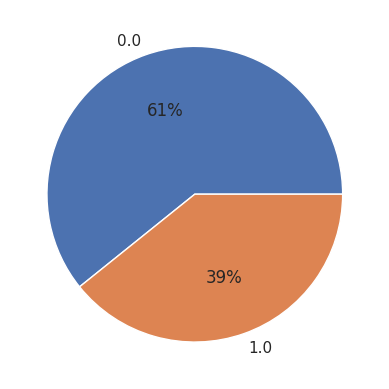

In [182]:
#pie chart za prikaz raspodele po klasama
labels = pd.unique(new_data['Cutoff_Class'])
countByClass = new_data.groupby('Cutoff_Class').size()
#colors = sns.color_palette('pastel')[0:2]
plt.pie(countByClass, labels = labels, autopct='%.0f%%')
plt.show()

Data before oversampling: (2009, 76)
Data after oversampling:  (2442, 76)


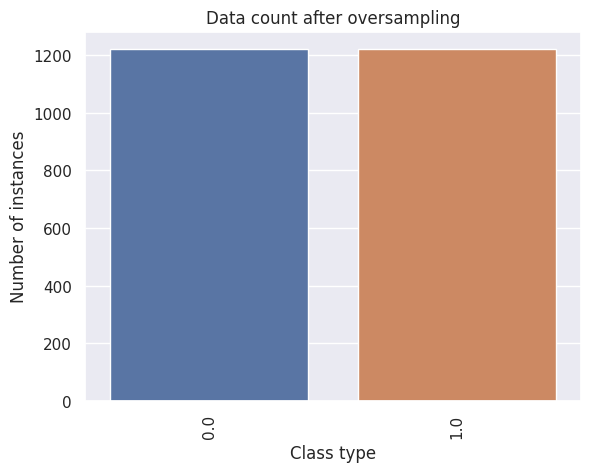

In [183]:
#oversampling sa SMOTE tehnikom
def oversampling(data):
    oversample = SMOTE()
    X_oversample, y_oversample = oversample.fit_resample(data[data.columns.difference(['Cutoff_Class'])], data['Cutoff_Class'])
    data_frame = pd.DataFrame(X_oversample)
    data_frame['Cutoff_Class'] = y_oversample
    print('Data before oversampling:', data.shape)
    print('Data after oversampling: ', X_oversample.shape)
    count_oversample = X_oversample.groupby('Cutoff_Class').size().sort_values()
    sns.barplot(x = labels, y = count_oversample, data = X_oversample)
    plt.title('Data count after oversampling')
    plt.xlabel('Class type')
    plt.xticks(rotation=90)
    plt.ylabel('Number of instances')
    plt.show()
    return data_frame
new_data_balanced = oversampling(new_data)

In [184]:
#pregled outlier vrednosti po kolonama
#detekcija outliera pomocu iqr
def find_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3=  df[col_name].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[((df[col_name]<(q1-1.5*iqr)) | (df[col_name]>(q3+1.5*iqr)))]
    return outliers
cols_to_use = new_data[new_data.columns.difference(zero_one)]
total_outlier_num=0
cols = cols_to_use.columns.values
num_cols=[]
for col in cols:
    num = find_outliers(cols_to_use, col)
    num_cols.append(len(num))
new_data_frame = pd.DataFrame()
new_data_frame['Feature']= cols
new_data_frame['Outliers']= num_cols
#print(new_data_frame.sort_values('Outliers', ascending=False))

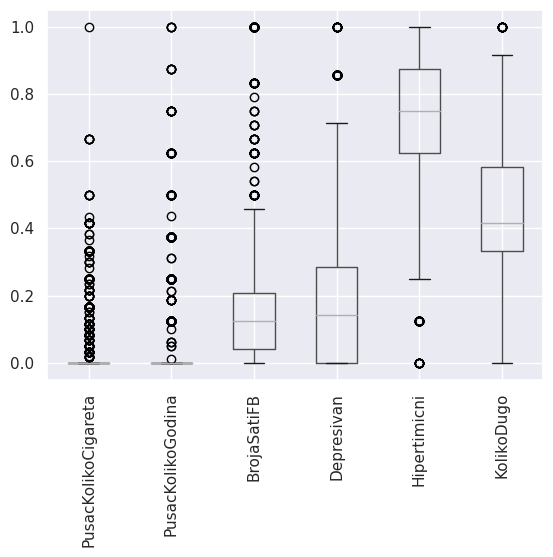

In [185]:
#ima smisla prikazivati outliere kod onih kolona gde se ne ponavljaju vrednosti iz predefinisanog skupa
outlier_cols = ['PusacKolikoCigareta','PusacKolikoGodina','BrojaSatiFB','Depresivan','Hipertimicni','KolikoDugo'] 
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
#pravimo kopiju da originalni set ne bi bio promenjen
outlier_data_norm = new_data.copy()
outlier_data_robust = new_data.copy()
outlier_data_norm[outlier_cols]= minmax_scaler.fit_transform(new_data[outlier_cols])
outlier_data_robust[outlier_cols]= robust_scaler.fit_transform(new_data[outlier_cols])
#prikaz outliera na boxplot-u
outlier_data_norm[outlier_cols].boxplot(rot=90)
#new_data[outlier_cols].boxplot(rot=90)
plt.show()
#outlier_data_robust[outlier_cols].boxplot(rot=90)

In [186]:
#detekcija i eliminacija outlier vrednosti primenom isolation forest-a
def delete_outliers(data):
    isolation_forest = IsolationForest(n_estimators = 100, contamination = 0.05, max_samples = 'auto')
    outlier_prediction = isolation_forest.fit_predict(data.values)
    print("Number of normal values detected: {}".format(outlier_prediction[outlier_prediction  == 1].sum()))
    print("Number of outliers detected: {}".format(abs(outlier_prediction[outlier_prediction == -1].sum())))
    data_no_outliers = data.copy()
    data_no_outliers['Is_Outlier'] = outlier_prediction
    data_no_outliers.drop(data_no_outliers[(data_no_outliers['Is_Outlier'] == -1)].index, axis = 0, inplace=True)
    data_no_outliers = data_no_outliers[data_no_outliers.columns.difference(['Is_Outlier'])]
    print('Number of values after eliminating outliers: ' + str(len(data_no_outliers)))
    return data_no_outliers
new_data_b_no_outliers = delete_outliers(new_data_balanced)

Number of normal values detected: 2319
Number of outliers detected: 123
Number of values after eliminating outliers: 2319


In [189]:
#normalizacija podataka -> normalizujemo sve kolone osim onih koje imaju samo binarne vrednosti 
cols_to_normalize = input_cols.columns.difference(zero_one)
min_max = MinMaxScaler()
new_data_norm = new_data_b_no_outliers.copy()
new_data_norm[cols_to_normalize] = min_max.fit_transform(new_data_norm[cols_to_normalize])

In [190]:
#standardizacija podataka
cols_to_standardize = input_cols.columns.difference(zero_one)
standard_scaler = StandardScaler()
new_data_standard = new_data_b_no_outliers.copy()
new_data_standard[cols_to_standardize] = standard_scaler.fit_transform(new_data_standard[cols_to_standardize])

In [191]:
#podela na train i test set
X_cols = new_data[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data['Cutoff_Class']

X_cols_preprocessed = new_data_norm[new_data_norm.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_preprocessed = new_data_norm['Cutoff_Class']

#treniranje sa neobradjenim i preprocesiranim skupom
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_cols_preprocessed, y_col_preprocessed, test_size=0.2)

In [ ]:
#DEO SA SELEKCIJOM FEATURE-A

In [192]:
#feture selection sa low variance metodom
def feature_selection_low_variance(treshold_val):
    variance = VarianceThreshold(threshold= treshold_val)
    variance = variance.fit(input_cols,output_col)
    good_features = variance.get_support()
    print(input_cols.columns[good_features])
print(feature_selection_low_variance(0.3))

Index(['Aktivnost1', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12',
       'Aktivnost13', 'Aktivnost14', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4',
       'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9',
       'BrojaSatiFB', 'EkonomskiPolozaj', 'FizAkt1', 'FizAkt2', 'FizAkt3',
       'KolikNajduze', 'KolikoDugo', 'Komunikacija1', 'Komunikacija2',
       'Komunikacija3', 'Komunikacija4', 'Predhodnih6meseci',
       'PusacKolikoCigareta', 'PusacKolikoGodina', 'Sadrzaj1', 'Sadrzaj10',
       'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Sadrzaj2', 'Sadrzaj3',
       'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9',
       'SkolaPoRegionu', 'SkolaPoTipu', 'Uspeh'],
      dtype='object')
None


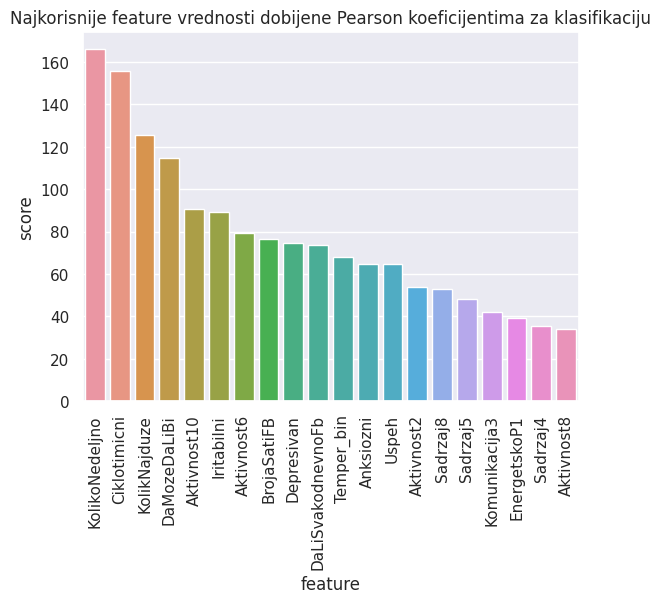

44       KolikoNedeljno
19         Ciklotimicni
42         KolikNajduze
22         DaMozeDaLiBi
1           Aktivnost10
40           Iritabilni
10           Aktivnost6
18          BrojaSatiFB
23           Depresivan
21    DaLiSvakodnevnoFb
69           Temper_bin
15            Anksiozni
70                Uspeh
6            Aktivnost2
65             Sadrzaj8
62             Sadrzaj5
47        Komunikacija3
25         EnergetskoP1
61             Sadrzaj4
12           Aktivnost8
Name: feature, dtype: object
None


In [193]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju
def feature_selection_pearson(n_features):
    best_features = SelectKBest(score_func = f_regression, k=n_features)
    calc_features = best_features.fit(input_cols,output_col)
    #odabir najboljih feature-a
    usefull_features = pd.DataFrame({'feature' : input_cols.columns.values, 'score' : calc_features.scores_})
    most_usefull_features = usefull_features.sort_values(by=['score'],ascending=False).head(n_features)
    #vizuelizacija dobijenih rezultata
    plt.title('Najkorisnije feature vrednosti dobijene Pearson koeficijentima za klasifikaciju')
    plt.xlabel('Feature score')
    plt.xticks(rotation=90)
    plt.ylabel('Naziv kolone')

    sns.barplot(x=most_usefull_features['feature'], y=most_usefull_features['score'])
    plt.show()
    feat_to_ret = most_usefull_features['feature']
    print(feat_to_ret)

print(feature_selection_pearson(20))    

Index(['KolikoNedeljno', 'KolikNajduze', 'DaMozeDaLiBi', 'Aktivnost10',
       'Ciklotimicni', 'Iritabilni', 'PUI', 'PUIcutoff', 'Cutoff_Class'],
      dtype='object')


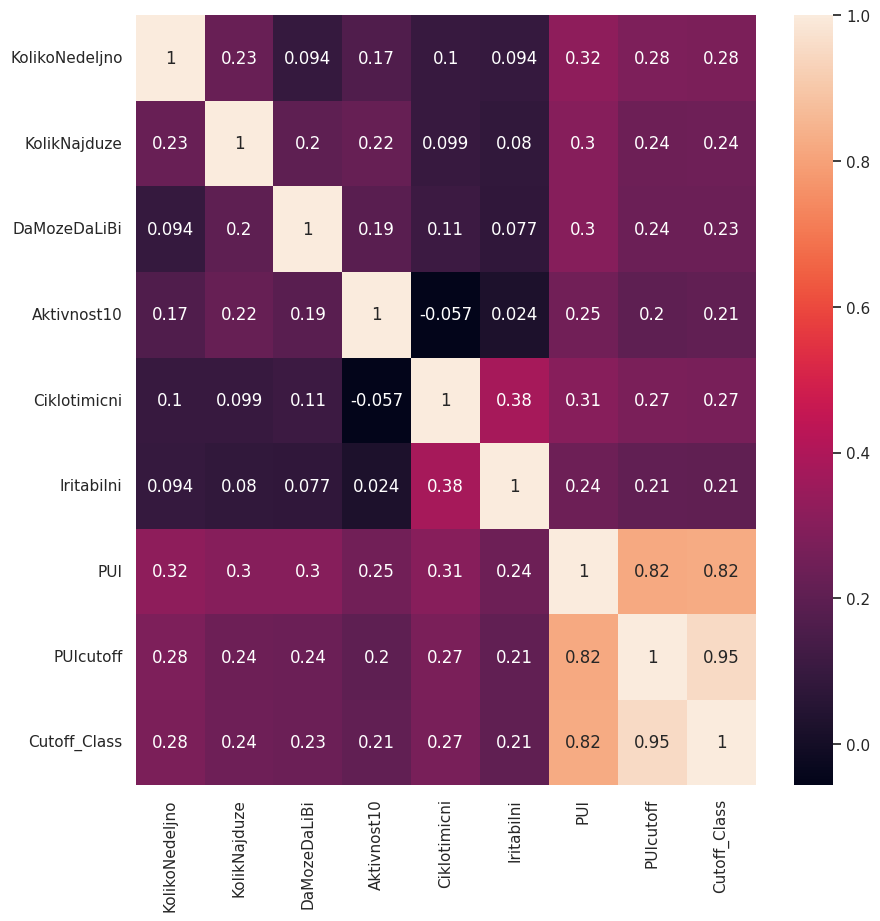

In [194]:
#prikaz heat mape gde se vide koeficijenti korelacije
def correlation_coef(corr_treshold):
    plt.figure(figsize=(10,10))
    correlation = new_data.corr()
    correlation_treshold = correlation['Cutoff_Class']
    good_features = correlation_treshold[abs(correlation_treshold > corr_treshold )]
    print(str(good_features.keys()))
    #print(good_features.sort_values(ascending=False))
    sns.heatmap(new_data[good_features.keys()].corr(), annot=True)
correlation_coef(0.2)

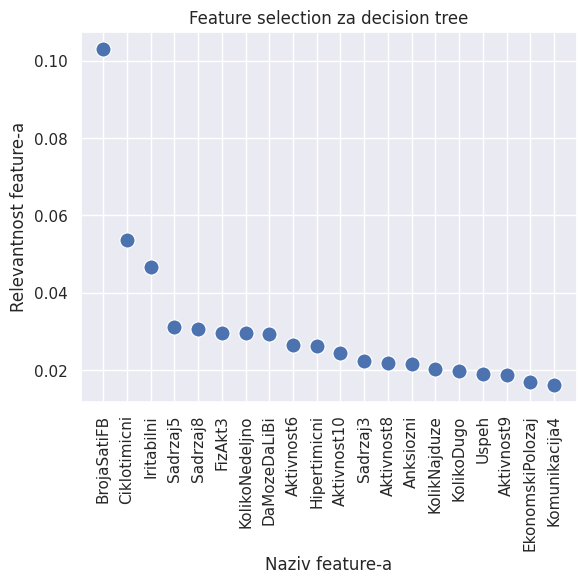

18         BrojaSatiFB
19        Ciklotimicni
40          Iritabilni
62            Sadrzaj5
65            Sadrzaj8
34             FizAkt3
44      KolikoNedeljno
22        DaMozeDaLiBi
10          Aktivnost6
37        Hipertimicni
1          Aktivnost10
60            Sadrzaj3
12          Aktivnost8
15           Anksiozni
42        KolikNajduze
43          KolikoDugo
70               Uspeh
13          Aktivnost9
24    EkonomskiPolozaj
48       Komunikacija4
Name: attr_names, dtype: object


In [195]:
#feature selection za decision tree
def feature_selection_decision_tree(n_features):
    sns.set()
    decision_tree.fit(X_cols, y_col)
    values = decision_tree.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.scatterplot(x = tree_features['attr_names'], y=tree_features['values'], s=120)
    title = 'Feature selection za decision tree'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_decision_tree_features = tree_features['attr_names']
    return best_decision_tree_features
print(feature_selection_decision_tree(20))

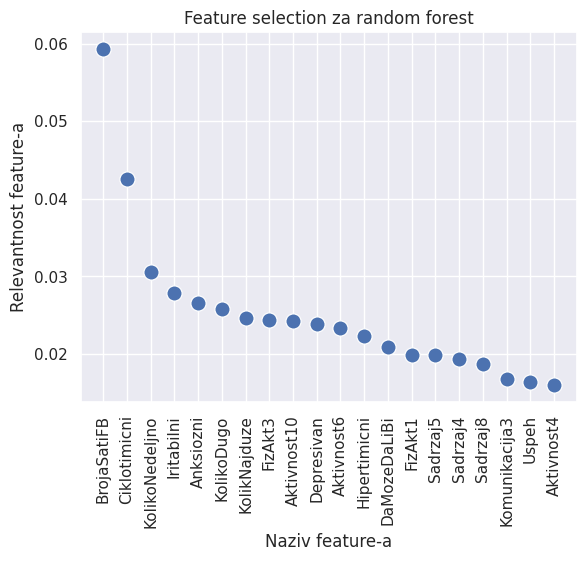

18       BrojaSatiFB
19      Ciklotimicni
44    KolikoNedeljno
40        Iritabilni
15         Anksiozni
43        KolikoDugo
42      KolikNajduze
34           FizAkt3
1        Aktivnost10
23        Depresivan
10        Aktivnost6
37      Hipertimicni
22      DaMozeDaLiBi
32           FizAkt1
62          Sadrzaj5
61          Sadrzaj4
65          Sadrzaj8
47     Komunikacija3
70             Uspeh
8         Aktivnost4
Name: attr_names, dtype: object


In [196]:
#feature selection za random forest
def feature_selection_random_forest(n_features):
    random_forest.fit(X_cols, y_col)
    values = random_forest.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.scatterplot(x = tree_features['attr_names'], y=tree_features['values'], s=120)
    title = 'Feature selection za random forest'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_random_forest_features = tree_features['attr_names']
    return best_random_forest_features
print(feature_selection_random_forest(20))

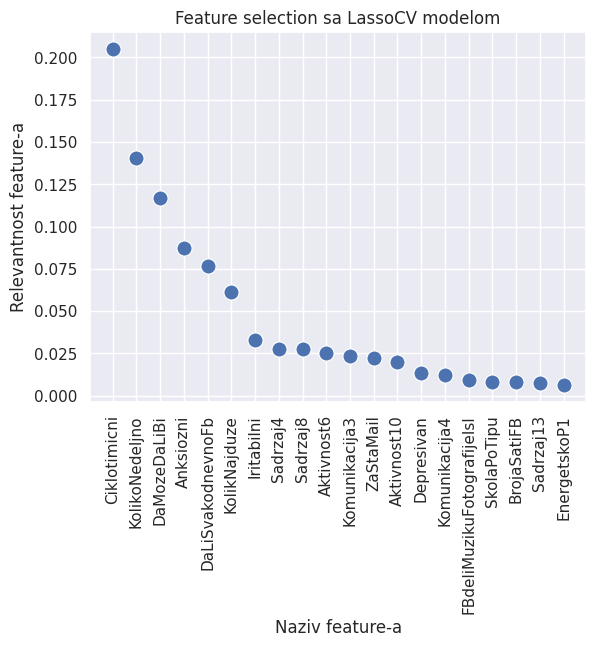

19                  Ciklotimicni
44                KolikoNedeljno
22                  DaMozeDaLiBi
15                     Anksiozni
21             DaLiSvakodnevnoFb
42                  KolikNajduze
40                    Iritabilni
61                      Sadrzaj4
65                      Sadrzaj8
10                    Aktivnost6
47                 Komunikacija3
71                     ZaStaMail
1                    Aktivnost10
23                    Depresivan
48                 Komunikacija4
28    FBdeliMuzikuFotografijeIsl
68                   SkolaPoTipu
18                   BrojaSatiFB
58                     Sadrzaj13
25                  EnergetskoP1
Name: attr_names, dtype: object


In [197]:
#feature selection sa LassoCV modelom 
def feature_selection_lasso_cv(n_features):
    lasso = LassoCV(cv=3)                                                   
    lasso.fit(X_cols, y_col)      
    lasso_values = lasso.coef_
    attr_names = X_cols.columns.values
    lasso_features = pd.DataFrame({'attr_names':attr_names, 'values':lasso_values})
    lasso_features = lasso_features.sort_values(by='values', ascending=False).head(n_features)       
    sns.scatterplot(x = lasso_features['attr_names'], y=lasso_features['values'], s=120)
    title = 'Feature selection sa LassoCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_lasso_features = lasso_features['attr_names']
    return best_lasso_features
print(feature_selection_lasso_cv(20))

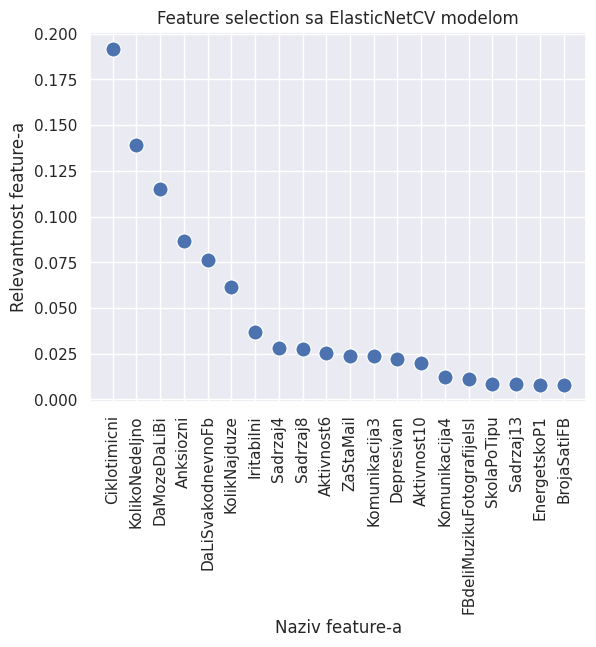

19                  Ciklotimicni
44                KolikoNedeljno
22                  DaMozeDaLiBi
15                     Anksiozni
21             DaLiSvakodnevnoFb
42                  KolikNajduze
40                    Iritabilni
61                      Sadrzaj4
65                      Sadrzaj8
10                    Aktivnost6
71                     ZaStaMail
47                 Komunikacija3
23                    Depresivan
1                    Aktivnost10
48                 Komunikacija4
28    FBdeliMuzikuFotografijeIsl
68                   SkolaPoTipu
58                     Sadrzaj13
25                  EnergetskoP1
18                   BrojaSatiFB
Name: attr_names, dtype: object


In [198]:
#feature selection koriscenjem ElasticNetCV modela
def feature_selection_elasticnet_cv(n_features):
    el_net = ElasticNetCV(cv=3)
    el_net.fit(X_cols, y_col)
    el_net_values = el_net.coef_
    attr_names = X_cols.columns.values
    el_net_features = pd.DataFrame({'attr_names':attr_names, 'values':el_net_values})
    el_net_features = el_net_features.sort_values(by='values', ascending=False).head(n_features)       
    sns.scatterplot(x = el_net_features['attr_names'], y=el_net_features['values'], s=120)
    title = 'Feature selection sa ElasticNetCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_el_net_features = el_net_features['attr_names']
    return best_el_net_features
print(feature_selection_elasticnet_cv(20))

Classification report sa svim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.64      0.84      0.73       251
         1.0       0.46      0.23      0.30       151

    accuracy                           0.61       402
   macro avg       0.55      0.53      0.52       402
weighted avg       0.57      0.61      0.57       402

Classification report sa redukovanim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.68      0.73      0.70       251
         1.0       0.48      0.42      0.45       151

    accuracy                           0.61       402
   macro avg       0.58      0.58      0.58       402
weighted avg       0.61      0.61      0.61       402



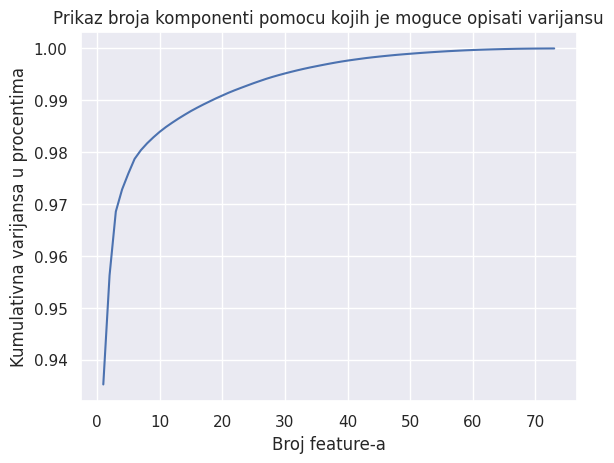

In [199]:

pca = PCA(n_components = None)
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.fit_transform(X_test)

fig, ax = plt.subplots()
x = np.arange(1,74, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.xlabel('Broj feature-a')
plt.ylabel('Kumulativna varijansa u procentima')
plt.title('Prikaz broja komponenti pomocu kojih je moguce opisati varijansu')
plt.plot(x,y)
clr = RandomForestClassifier()
clr.fit(X_train_new, y_train)

y_pred_pca = clr.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred_pca)
print('Classification report sa svim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))

#broj komponenti predstavljen vrednoscu nakon koje se uocava zaravnjenje krive
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
clr = RandomForestClassifier()
clr.fit(X_train_pca, y_train)

y_pred_pca = clr.predict(X_test_pca)
print('Classification report sa redukovanim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))


In [200]:
#DEO SA KLASIFIKACIJOM

#modeli bez podesavanja hiperparametara
decision_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()
random_forest = RandomForestClassifier()
grad_boost_class = GradientBoostingClassifier()

In [201]:
# k-fold cross-validation za razne modele ML-a
models = [
            ('Decision Tree', decision_tree), 
            ('Gaussian Naive Bayes', naive_bayes), 
            ('K-Nearest Neighbors', knn), 
            ('Random Forest', random_forest),
            ('Gradient Boosting Classifier', grad_boost_class)]
results = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
names = []
k_fold = StratifiedKFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['accuracy', 'precision','recall','f1'])
    results.append(cv_res)
    results_accuracy.append(cv_res['test_accuracy'].mean())
    results_precision.append(cv_res['test_precision'].mean())
    results_recall.append(cv_res['test_recall'].mean())
    results_f1.append(cv_res['test_f1'].mean())
    names.append(name)

In [202]:
#tabelarni prikaz rezultata za razlicite modele bez preprocesiranja
diff_models_res = pd.DataFrame({'Model name': names,
                                'Accuracy': results_accuracy,
                                'Precision': results_precision, 
                                'Recall': results_recall,
                                'F1': results_f1})
print(diff_models_res)

                     Model name  Accuracy  Precision    Recall        F1
0                 Decision Tree  0.640959   0.548747  0.544816  0.545618
1          Gaussian Naive Bayes  0.692011   0.600544  0.670486  0.632877
2           K-Nearest Neighbors  0.616033   0.523226  0.368800  0.431766
3                 Random Forest  0.730023   0.699889  0.554588  0.617416
4  Gradient Boosting Classifier  0.740575   0.694028  0.618700  0.653629


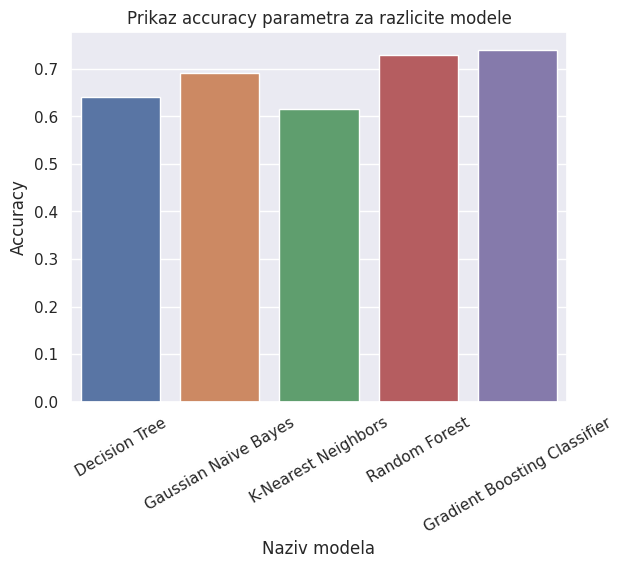

In [203]:
#vizuelizacija dobijenih rezultata za accuracy
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'accuracy':results_accuracy})
sns.barplot(x = frame['model_name'], y=frame['accuracy'])
title = 'Prikaz accuracy parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Accuracy')
plt.show()

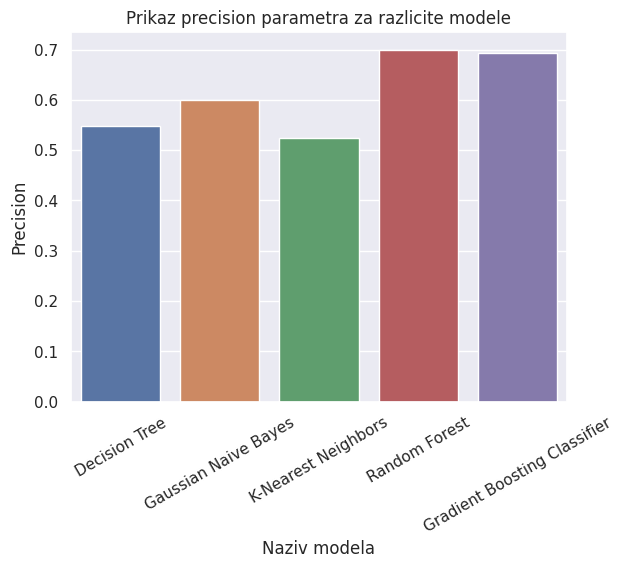

In [204]:
#vizuelizacija dobijenih rezultata za precision
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'precision':results_precision})
sns.barplot(x = frame['model_name'], y=frame['precision'])
title = 'Prikaz precision parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Precision')
plt.show()

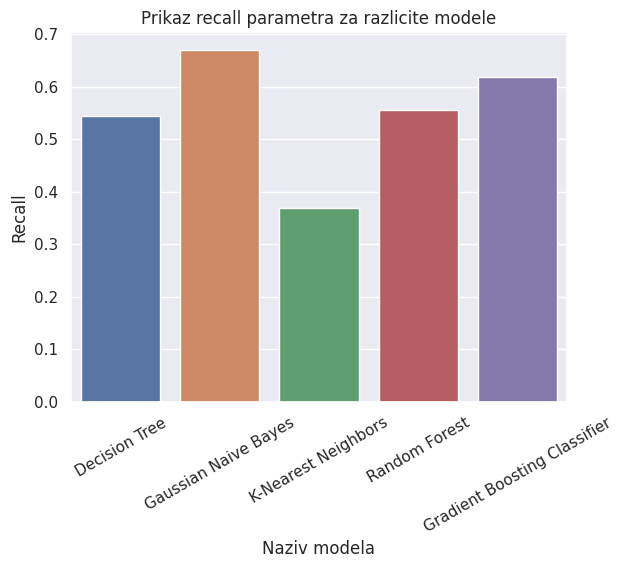

In [205]:
#vizuelizacija dobijenih rezultata za recall
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'recall':results_recall})
sns.barplot(x = frame['model_name'], y=frame['recall'])
title = 'Prikaz recall parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Recall')
plt.show()

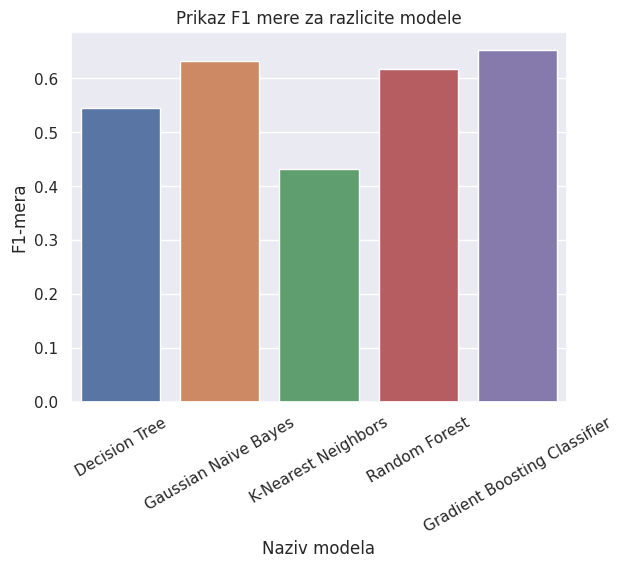

In [206]:
#vizuelizacija dobijenih rezultata za f1
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'f1':results_f1})
sns.barplot(x = frame['model_name'], y=frame['f1'])
title = 'Prikaz F1 mere za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('F1-mera')
plt.show()

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8)
Accuracy za dataset sa svim feature-ima: 0.70
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.78       251
         1.0       0.65      0.44      0.52       151

    accuracy                           0.70       402
   macro avg       0.68      0.65      0.65       402
weighted avg       0.69      0.70      0.68       402



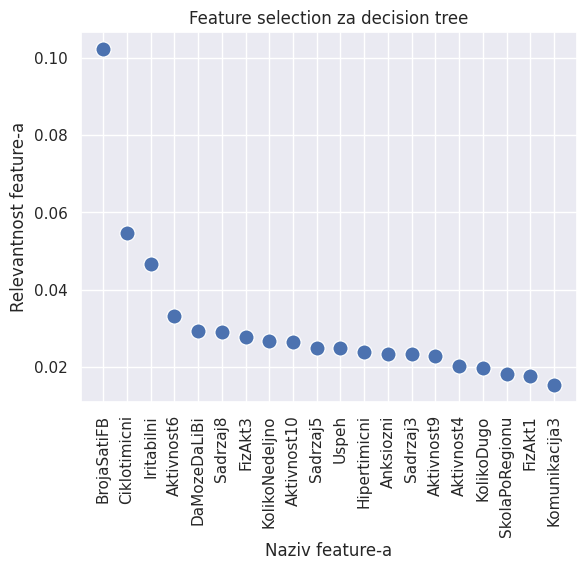

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9)
Accuracy za preprocesiran dataset: 0.77
Classification report za preprocesiran dataset: 
              precision    recall  f1-score   support

         0.0       0.72      0.87      0.78       225
         1.0       0.84      0.68      0.75       239

    accuracy                           0.77       464
   macro avg       0.78      0.77      0.77       464
weighted avg       0.78      0.77      0.77       464



In [207]:
#podesavanje hiperparametara za decision tree
parameters = {'max_leaf_nodes': list(range(2,10)), 
              'min_samples_split':[2,3,4],
              'max_depth': [2,3,5,10],
              'criterion': ['gini', 'entropy']}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela bez preprocesiranja i sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa preprocesiranjem i selekcijom najboljih feature-a
features_dtc = feature_selection_decision_tree(20)
best_model = grid_search_cv.fit(X_train_p[features_dtc], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_dtc])
print('Accuracy za preprocesiran dataset: {:.2f}'.format(best_model.score(X_test_p[features_dtc], y_test_p)))
print('Classification report za preprocesiran dataset: ')
print(classification_report(y_test_p, y_preds))

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(max_depth=9, max_features=3, n_estimators=40)
Accuracy za dataset sa svim feature-ima: 0.73
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       251
         1.0       0.72      0.48      0.57       151

    accuracy                           0.73       402
   macro avg       0.73      0.68      0.69       402
weighted avg       0.73      0.73      0.72       402



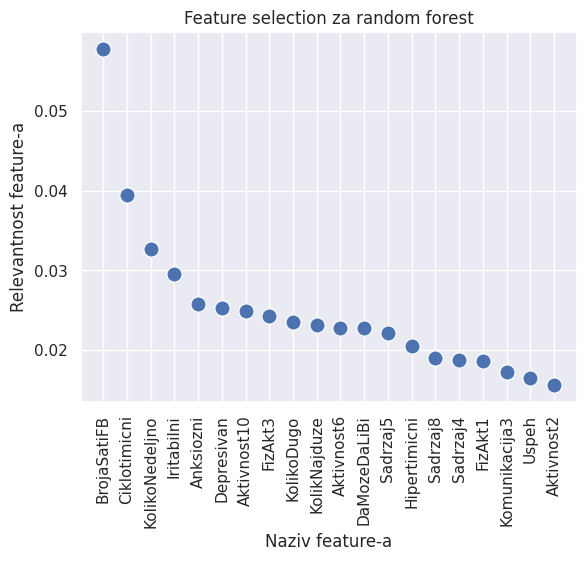

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(criterion='entropy', max_depth=9, max_features=5,
                       n_estimators=40)
Accuracy za dataset sa preprocesiranim podacima: 0.78
Classification report za dataset sa preprocesiranim podacima: 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       225
         1.0       0.83      0.74      0.78       239

    accuracy                           0.78       464
   macro avg       0.79      0.79      0.78       464
weighted avg       0.79      0.78      0.78       464



In [208]:
#podesavanje hiperparametara za random forest
parameters = {'n_estimators':[10,20,40], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela bez preprocesiranja i sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa selekcijom feature-a i preprocesiranim podacima
features_rf = feature_selection_random_forest(20)
best_model = grid_search_cv.fit(X_train_p[features_rf], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_rf])
print('Accuracy za dataset sa preprocesiranim podacima: {:.2f}'.format(best_model.score(X_test_p[features_rf], y_test_p)))
print('Classification report za dataset sa preprocesiranim podacima: ')
print(classification_report(y_test_p, y_preds))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')
Accuracy za model sa svim feature-ima bez preprocesiranja: 0.6716417910447762
Classification report za model sa svim feature-ima bez preprocesiranja: 
              precision    recall  f1-score   support

         0.0       0.68      0.91      0.78       251
         1.0       0.65      0.28      0.39       151

    accuracy                           0.67       402
   macro avg       0.66      0.59      0.58       402
weighted avg       0.67      0.67      0.63       402



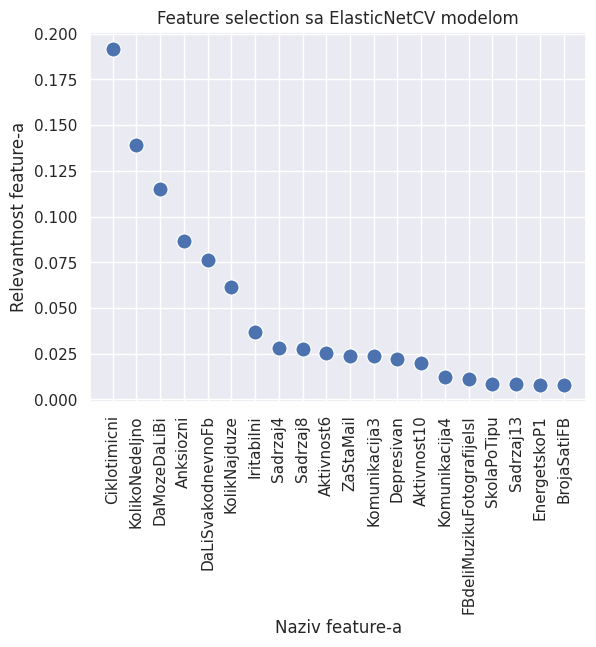

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')
Accuracy za model sa Elastic-Netom i preprocesiranim podacima: 0.7543103448275862
Classification report sa Elastic-Netom i sa preprocesiranim podacima: 
              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       225
         1.0       0.80      0.69      0.74       239

    accuracy                           0.75       464
   macro avg       0.76      0.76      0.75       464
weighted avg       0.76      0.75      0.75       464



In [209]:
#podesavanje hiperparametara za K-Nearest-Neighbors
parameters = {'n_neighbors': list(range (1,21)), 
              'metric': ['euclidean', 'manhattan', 'minkowski'], 
              'weights': ['uniform', 'distance']}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima bez preprocesiranja: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima bez preprocesiranja: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa preprocesiranim podacima i selekcijom feature-a

#treniranje modela sa Elastic-Net feature-ima

features_elastic = feature_selection_elasticnet_cv(20)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy za model sa Elastic-Netom i preprocesiranim podacima: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report sa Elastic-Netom i sa preprocesiranim podacima: ')
print(classification_report(y_test_p, y_preds))


Fitting 10 folds for each of 90 candidates, totalling 900 fits
GradientBoostingClassifier(n_estimators=70)
Accuracy: 0.763681592039801
Classification report: 
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82       251
         1.0       0.71      0.64      0.67       151

    accuracy                           0.76       402
   macro avg       0.75      0.74      0.74       402
weighted avg       0.76      0.76      0.76       402



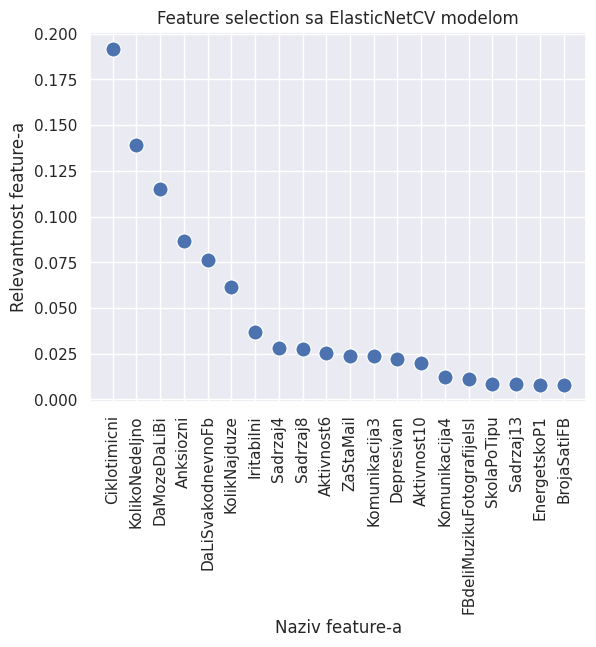

Fitting 10 folds for each of 90 candidates, totalling 900 fits
GradientBoostingClassifier(n_estimators=70)
Accuracy: 0.7586206896551724
Classification report: 
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       225
         1.0       0.78      0.73      0.76       239

    accuracy                           0.76       464
   macro avg       0.76      0.76      0.76       464
weighted avg       0.76      0.76      0.76       464



In [210]:
#podesavanje hiperparametara za gradient boosting
parameters = {"n_estimators":[5,50,70],
              "max_depth":[1,3,5,7,9,11],
              "learning_rate":[0.01,0.1,1,10,100]}
grid_search_cv = GridSearchCV(GradientBoostingClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima i bez preprocesiranja podataka
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy: {}'.format(best_model.score(X_test, y_test)))
print('Classification report: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa ElasticNet feature-ima i preprocesiranim podacima
features_elastic = feature_selection_elasticnet_cv(20)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report: ')
print(classification_report(y_test_p, y_preds))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=1e-05)
Accuracy za model sa svim feature-ima: 0.7139303482587065
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.76       251
         1.0       0.61      0.66      0.63       151

    accuracy                           0.71       402
   macro avg       0.70      0.70      0.70       402
weighted avg       0.72      0.71      0.72       402



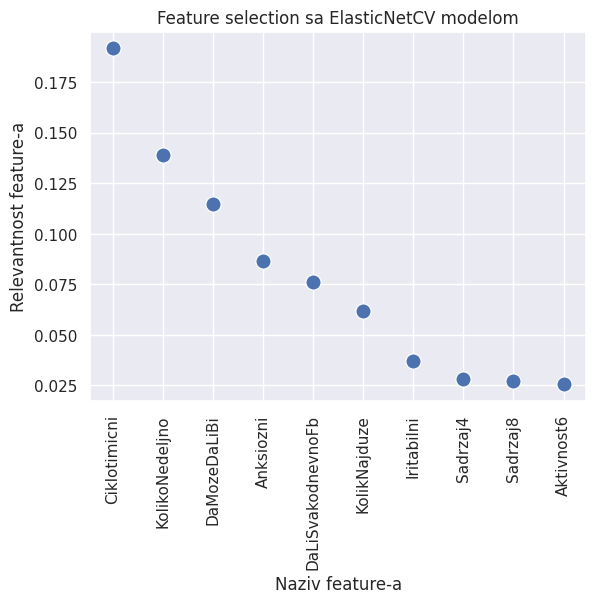

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.15199110829529336)
Accuracy za model sa Elastic-net feature-ima: 0.7112068965517241
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71       225
         1.0       0.73      0.71      0.72       239

    accuracy                           0.71       464
   macro avg       0.71      0.71      0.71       464
weighted avg       0.71      0.71      0.71       464



In [216]:
#podesavanje hiperparametara za Naive Bayes
parameters = {'var_smoothing': np.logspace(0,-9,num=100)}
grid_search_cv = GridSearchCV(GaussianNB(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima i bez preprocesiranja podataka
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa Elastic-Net feature-ima i preprocesiranim podacima 
features_elastic = feature_selection_elasticnet_cv(10)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy za model sa Elastic-net feature-ima: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test_p, y_preds))


In [36]:
#genetski algoritmi
parameters = {'n_estimators':[10,50,100], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 11),
              'max_leaf_nodes': Integer(2, 15),
              'n_estimators': Integer(100,300)}

clf = RandomForestClassifier()

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv,
                              scoring='accuracy',
                              n_jobs=-1,
                              param_grid = param_grid,
                              verbose=True)

evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.674052	0.0450218  	0.728677   	0.604854   
1  	100   	0.709793	0.0255086  	0.731794   	0.615433   
2  	100   	0.722252	0.00622666 	0.734917   	0.710019   
3  	100   	0.725813	0.00404461 	0.734917   	0.712516   
4  	100   	0.72697 	0.00418411 	0.734917   	0.711264   
5  	100   	0.727591	0.00339745 	0.734917   	0.718735   
6  	100   	0.727903	0.00402021 	0.733672   	0.714376   
7  	100   	0.728922	0.0037066  	0.733672   	0.719358   
8  	100   	0.729694	0.00308837 	0.734289   	0.723702   
9  	100   	0.729571	0.00347877 	0.738011   	0.723081   
10 	100   	0.730902	0.00344206 	0.738011   	0.720599   
11 	100   	0.730178	0.00382303 	0.734915   	0.719347   
12 	100   	0.730491	0.00341952 	0.734906   	0.719984   
13 	100   	0.730852	0.00282256 	0.734919   	0.724335   
14 	100   	0.731126	0.00319205 	0.734919   	0.723719   
15 	100   	0.730355	0.00370469 	0.734906   	0.722451   
16 	100   	0.730281	0.0042765  	0.734906   	0.71

GASearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(bootstrap=False, max_depth=6,
                                            max_leaf_nodes=15,
                                            min_weight_fraction_leaf=0.018485202503559072,
                                            n_estimators=288),
           n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categorical object at 0x7fcf605ac0a0>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7fcf605ade10>,
                       'max_leaf_nodes': <sklearn_genetic.space.space.Integer object at 0x7fcf605ae170>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x7fcf605ac700>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7fcf605afb50>},
           return_train_score=True, scoring='accuracy')

In [37]:
#rezultati koriscenjem genetskih algoritama
y_predict_ga = evolved_estimator.predict(X_test)
print(accuracy_score(y_test, y_predict_ga))

0.7238805970149254


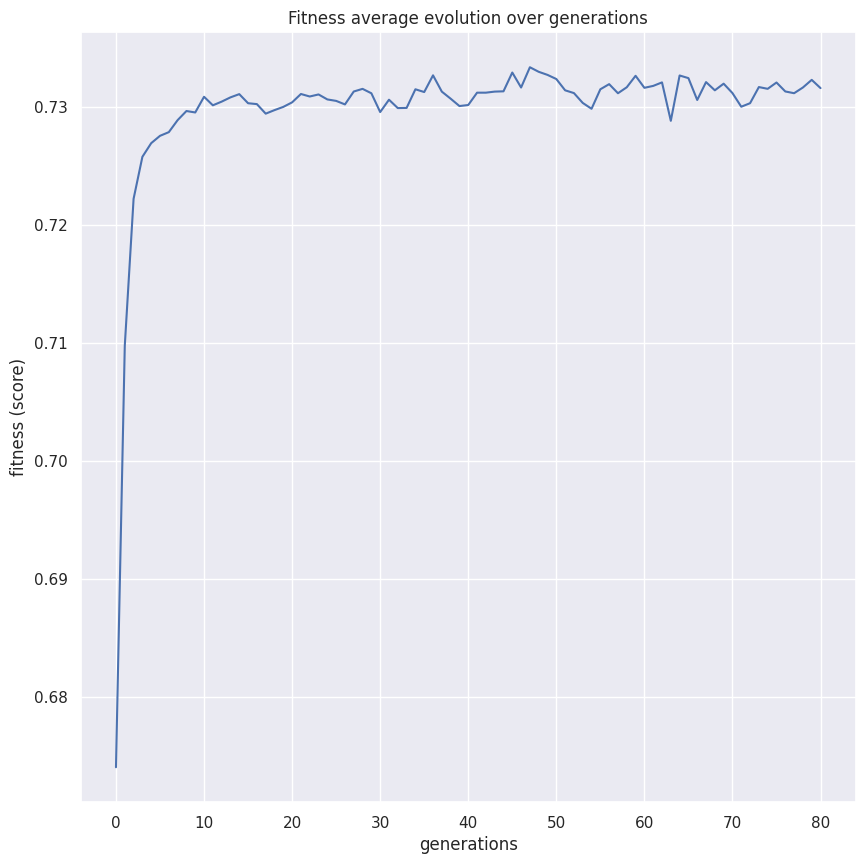

In [43]:
#prikaz evolucije fitnes funkcije kroz generacije
plot_fitness_evolution(evolved_estimator)
plt.show()

In [44]:
#feature selection koriscenjem genetskih algoritama
clf = RandomForestClassifier()
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    keep_top_k=2,
    elitism=True,
)
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.694072	0.0206974  	0.71812    	0.62165    
1  	60    	0.707639	0.0103571  	0.723725   	0.67704    
2  	60    	0.715066	0.00512703 	0.723101   	0.701935   
3  	60    	0.718239	0.00548208 	0.734917   	0.706909   
4  	60    	0.720936	0.00553438 	0.733676   	0.706909   
5  	60    	0.723635	0.00546419 	0.733676   	0.70816    
6  	60    	0.725896	0.00418881 	0.734924   	0.71749    
7  	60    	0.725834	0.00442292 	0.734924   	0.717495   
8  	60    	0.729174	0.00611668 	0.738033   	0.714378   
9  	60    	0.732474	0.00447587 	0.738033   	0.724339   
10 	60    	0.7349  	0.00336457 	0.741772   	0.727459   
11 	60    	0.73382 	0.00412748 	0.739278   	0.722474   
12 	60    	0.733654	0.00400645 	0.739278   	0.722469   
13 	60    	0.732867	0.00489383 	0.739888   	0.719367   
14 	60    	0.735044	0.00297105 	0.739888   	0.7287     
15 	60    	0.734215	0.00405174 	0.739888   	0.72434    
16 	60    	0.734381	0.00331091 	0.739888   	0.72

GAFeatureSelectionCV(estimator=RandomForestClassifier(), generations=20,
                     keep_top_k=2, n_jobs=-1, population_size=30,
                     return_train_score=True, scoring='accuracy')

In [1]:
#feature selection koriscenjem genetskih alogiritama 
gen_opt_features = evolved_estimator.best_features_
gen_df = pd.DataFrame({'feature': X_train.columns, 'is_used':gen_opt_features})

def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

selected_features = gen_df[gen_df['is_used'] == True]['feature']
gen_df.style.applymap(highlight_cells)

NameError: name 'evolved_estimator' is not defined

In [104]:
#predikcija koriscenjem feature-a odabranih genetskim algoritmom
y_predict_ga = evolved_estimator.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_predict_ga)
print(accuracy)

0.7711442786069652


In [29]:
#radimo sa standardizovanim datasetom
X_cols_norm = new_data_norm[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_norm = new_data_norm['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)

In [35]:
#neuronske mreze za klasifikaciju
X_cols = new_data_standard[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data_standard['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)
mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter= 90,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)
trained_model = mlp.fit(X_train, y_train)
y_preds = trained_model.predict(X_test)
plt.show()
print('Accuracy za dataset sa MLP-om: {:.2f}'.format(trained_model.score(X_test, y_test)))
print('Classification report za model sa MLP-om: ')
print(classification_report(y_test, y_preds))

Iteration 1, loss = 0.62975209
Iteration 2, loss = 0.51879438
Iteration 3, loss = 0.47803540
Iteration 4, loss = 0.43949501
Iteration 5, loss = 0.40075589
Iteration 6, loss = 0.36365927
Iteration 7, loss = 0.32505653
Iteration 8, loss = 0.28620452
Iteration 9, loss = 0.25925794
Iteration 10, loss = 0.21972553
Iteration 11, loss = 0.19967769
Iteration 12, loss = 0.18104708
Iteration 13, loss = 0.16190567
Iteration 14, loss = 0.12326847
Iteration 15, loss = 0.10477429
Iteration 16, loss = 0.08694277
Iteration 17, loss = 0.07245890
Iteration 18, loss = 0.06173882
Iteration 19, loss = 0.04399697
Iteration 20, loss = 0.03847840
Iteration 21, loss = 0.02816603
Iteration 22, loss = 0.02321655
Iteration 23, loss = 0.01967277
Iteration 24, loss = 0.01610193
Iteration 25, loss = 0.01388881
Iteration 26, loss = 0.01242705
Iteration 27, loss = 0.01110491
Iteration 28, loss = 0.01001181
Iteration 29, loss = 0.00913140
Iteration 30, loss = 0.00863764
Iteration 31, loss = 0.00801167
Iteration 32, los

In [39]:
#auto-sklearn za klasifikaciju
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))
print(automl.leaderboard())

Accuracy score 0.746268656716418
          rank  ensemble_weight           type      cost  duration
model_id                                                          
5            1             0.14  random_forest  0.242938  2.457265
18           2             0.04  random_forest  0.244821  2.536645
2            3             0.20  random_forest  0.246704  2.158461
6            4             0.08  random_forest  0.246704  2.341989
15           5             0.08  random_forest  0.256121  2.601341
11           6             0.16  random_forest  0.258004  3.490302
16           7             0.30    extra_trees  0.265537  6.225641


In [162]:
#DEO SA REGRESIJOM

In [40]:
linear = LinearRegression(n_jobs = -1)
logistic = LogisticRegression(max_iter=10000, solver='lbfgs')
lasso = Lasso(random_state = 42)
ridge = Ridge(random_state = 42)
kr = KernelRidge()
el_net= ElasticNet(random_state=42)
gradient_boost = GradientBoostingRegressor(random_state =42)
random_forest =  RandomForestRegressor(n_jobs = -1)

In [41]:
input_cols_reg = new_data_standard[new_data_standard.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col_reg = new_data_standard['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg, output_col_reg, test_size=0.3)

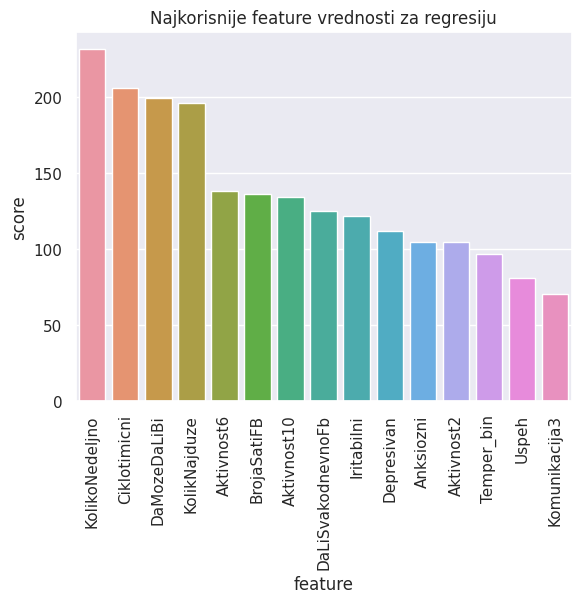

In [42]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za regresiju
best_features = SelectKBest(score_func = f_regression, k=15)
calc_features = best_features.fit(input_cols_reg,output_col_reg)
#odabir najboljih feature-a
usefull_features = pd.DataFrame({'feature' : input_cols_reg.columns.values, 'score' : calc_features.scores_})
most_usefull_features_reg = usefull_features.sort_values(by=['score'],ascending=False).head(15)
#vizuelizacija dobijenih rezultata
plt.title('Najkorisnije feature vrednosti za regresiju')
plt.xlabel('Feature score')
plt.xticks(rotation=90)
plt.ylabel('Naziv kolone')

sns.barplot(x=most_usefull_features_reg['feature'], y=most_usefull_features_reg['score'])
plt.show()

In [43]:
#pravljenje seta sa najznacajnijim feature-ima za regresiju
input_cols_reg_new = new_data[most_usefull_features_reg['feature']]
output_col_reg_new = new_data['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg_new, output_col_reg_new, test_size=0.2)

In [44]:
#odabir modela za regresiju
models = [  ('Linear Regression', linear), 
            ('Logistic Regression', logistic),
            ('Lasso', lasso), 
            ('Ridge', ridge), 
            ('Elastic Net', el_net), 
            ('Gradient Boosting', gradient_boost),
            ('Random Forest Regression', random_forest)]
results = []
results_mean_squared_error = []
results_root_mean_squared_error = []
results_r2_score = []
names = []
k_fold = KFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error','r2'])
    results.append(cv_res)
    results_mean_squared_error.append(cv_res['test_neg_mean_squared_error'].mean())
    results_root_mean_squared_error.append(cv_res['test_neg_root_mean_squared_error'].mean())
    results_r2_score.append(cv_res['test_r2'].mean())
    names.append(name)

                 model_name  neg_mean_squared_error
0         Linear Regression             -125.371367
1       Logistic Regression             -194.605509
2                     Lasso             -149.103258
3                     Ridge             -125.358402
4               Elastic Net             -148.196487
5         Gradient Boosting             -126.684727
6  Random Forest Regression             -130.002434


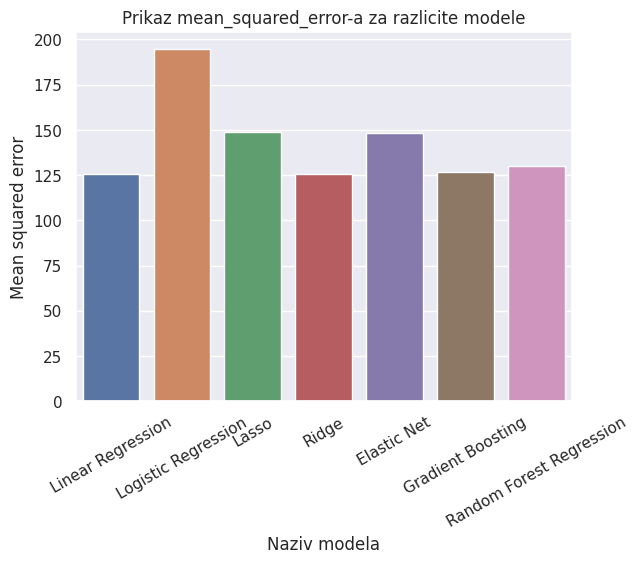

In [45]:
#vizuelizacija dobijenih rezultata za neg_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_mean_squared_error':results_mean_squared_error})
sns.barplot(x = frame['model_name'], y=abs(frame['neg_mean_squared_error']))
print(frame)
title = 'Prikaz mean_squared_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Mean squared error')
plt.show()

                 model_name  neg_root_mean_squared_error
0         Linear Regression                   -11.172718
1       Logistic Regression                   -13.927147
2                     Lasso                   -12.195889
3                     Ridge                   -11.172195
4               Elastic Net                   -12.157890
5         Gradient Boosting                   -11.240330
6  Random Forest Regression                   -11.384714


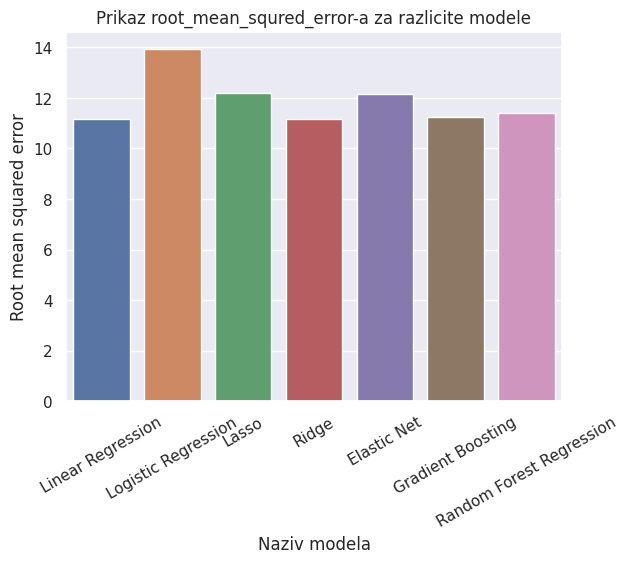

In [46]:
#vizuelizacija dobijenih rezultata za root_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_root_mean_squared_error':results_root_mean_squared_error})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['neg_root_mean_squared_error']))
title = 'Prikaz root_mean_squred_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Root mean squared error')
plt.show()

                 model_name        r2
0         Linear Regression  0.361315
1       Logistic Regression  0.007998
2                     Lasso  0.240683
3                     Ridge  0.361385
4               Elastic Net  0.245606
5         Gradient Boosting  0.353222
6  Random Forest Regression  0.336804


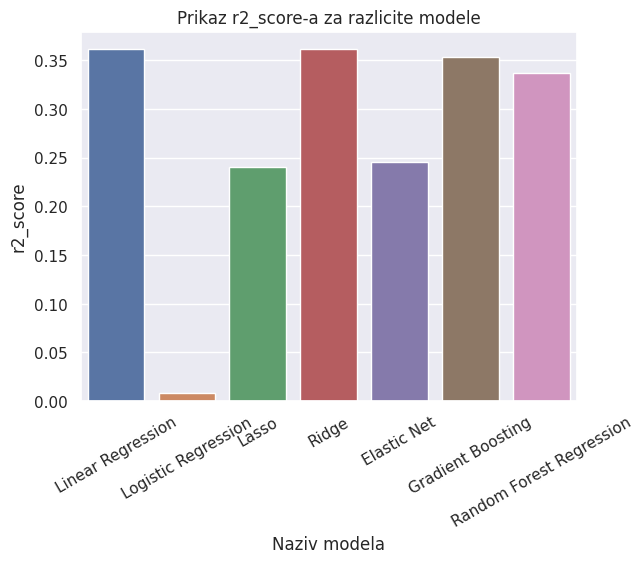

In [47]:
#vizuelizacija dobijenih rezultata za r2_score
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'r2':results_r2_score})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['r2']))
title = 'Prikaz r2_score-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('r2_score')
plt.show()

In [48]:
#auto-sklearn za regresiju
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
print(automl.leaderboard())
test_predictions = automl.predict(X_test)
print("Test R2 score:", r2_score(y_test, test_predictions))

          rank  ensemble_weight           type      cost   duration
model_id                                                           
11           1             0.52  liblinear_svr  0.602076   0.616087
4            2             0.28    extra_trees  0.609489  13.913999
2            3             0.20  random_forest  0.624591   2.463046
Test R2 score: 0.3763771096018068
